# Naive Bayes

Naive Bayes algorithms are a set of supervised statistical classification machine learning algorithms based on the Bayes probability theorem.

Bayes theorem states that:

$$P(A|B) = \frac{P(B/A) * P(A)}{P(B)}$$
$$P(A|B) = \frac{P(B/A) * P(A)}{P(B/A) * P(A) + P(C/A) * P(A)}$$

An important assumption made by Bayes theorem is that the value of a particular feature is independent from the value of any other feature for a given the class.

For sentiment analysis on the given dataset, we have used the method "Bag of Words". In this method we create a dictionary/vocabulary of distinct words (which tells us about the sentiment of the sentence). Here, words are taken as features used to estimate the sentiment.

The prior probability of the positive and negitive classes, along with, the probability of occurance of each word (feature) are calculated.

<b>Workflow</b>
<ol>
    <li>Calculate the prior probability for each class labels</li>
    <li>Find likelihood probability with each attribute for each class</li>
    <li>Put these value in Bayes Formula and calculate posterior probability</li>
    <li>See which class has a higher probability, given the input belongs to the higher probability class.</li>
</ol>

## Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import os
import re

## Data Preprocessing

In [3]:
path = os.getcwd()
print(path)

/home/pavan/Desktop/Projects/ML-assignment/Naive-Bayes


In [4]:
file1 = open('dataset_NB.txt', 'r')
Lines = file1.readlines()

<b>Insert data from txt file to a dictionary.
Sepearte out the Labels.</b>

In [5]:
dict_data = {'text':[], 'label':[]}
for i in Lines:
  label = i[-2]
  string = i[:-2]
  dict_data['text'].append(string)
  dict_data['label'].append(label)
dict_data['label'][-1] = '0'

In [6]:
dict_data['text'][:10]

['So there is no way for me to plug it in here in the US unless I go by a converter.  ',
 'Good case, Excellent value. ',
 'Great for the jawbone.  ',
 'Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!! ',
 'The mic is great.   ',
 'I have to jiggle the plug to get it to line up right to get decent volume.  ',
 'If you have several dozen or several hundred contacts, then imagine the fun of sending each of them one by one. ',
 'If you are Razr owner...you must have this! ',
 'Needless to say, I wasted my money. ',
 'What a waste of money and time!.    ']

In [7]:
dict_data['label'][:10]

['0', '1', '1', '0', '1', '0', '0', '1', '0', '0']

<b>Create a Dataframe with the data from "dict_data".
Then, visualize the data.</b>

In [8]:
df = pd.DataFrame(dict_data)

In [9]:
df

,text,label
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1
...,...,...
995,The screen does get smudged easily because it ...,0
996,What a piece of junk.. I lose more calls on th...,0
997,Item Does Not Match Picture.,0
998,The only thing that disappoint me is the infra...,0


In [10]:
df.head()

,text,label
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


In [11]:
n = df['label'].value_counts()
n = n.to_numpy()

<b>As shown below, there are 500 lines with postive and 500 lines with negitive sentiment.
This is an eqaully distributed dataset.</b>

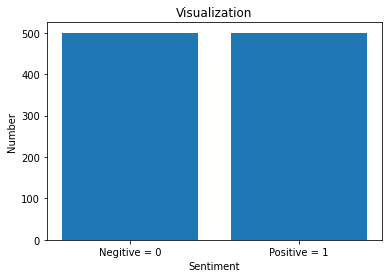

In [12]:
plt.bar(['Negitive = 0','Positive = 1'], n)
plt.xlabel('Sentiment')
plt.ylabel('Number')
plt.title('Visualization')
plt.show()

<b>Function Defined for processing the text data. This includes:
    <ol>
        <li>Removing stop words</li>
        <li>Removing commas, fullstops, hyphens</li>
        <li>Numerical Data</li>
    </ol>
</b>

In [13]:
def data_preprocess(textdata):
    Processed =[]

    alphaPattern = r"[^\w\s]"
    numPattern = r"[\d]"
    sequenceFind = r"(.)\1\1+"
    sequenceReplace = r"\1\1"

    for line in textdata:
        line = line.lower()
        line = re.sub(alphaPattern, ' ', line)
        line = re.sub(numPattern, ' ', line)
        line = re.sub(sequenceFind, sequenceReplace, line)

        lineWords = ''
        for text in line.split():
            if len(text)>2:
                lineWords += (text +' ')

        Processed.append(lineWords)

    return Processed

In [14]:
dict_data['text'] = data_preprocess(dict_data['text'])

In [15]:
dict_data['text'][0:10]

['there way for plug here the unless converter ',
 'good case excellent value ',
 'great for the jawbone ',
 'tied charger for conversations lasting more than minutes major problems ',
 'the mic great ',
 'have jiggle the plug get line right get decent volume ',
 'you have several dozen several hundred contacts then imagine the fun sending each them one one ',
 'you are razr owner you must have this ',
 'needless say wasted money ',
 'what waste money and time ']

## Vectorizer

<b>Created a list of stop words, which do not contribute to the sentiment of a text.</b>

In [16]:
file2 = open('stop_words.txt', 'r')
stop_words = file2.readlines()
stop_words = [word[:-1] for word in stop_words]

In [17]:
label = dict_data['label']
for i in range(0, len(label)): 
    label[i] = int(label[i]) 
dict_data['label'] = label

In [18]:
def vectorizer(data, label):
    '''
    Takes a list of sentences as input.
    Returns a dictionary containing unique words as keys and their respective count as values.
    '''
    dict_words = {}
    
    for line, label in zip(data, label):
        for text in line.split():
            if text not in stop_words:
                pair = (text, label)
                if pair in dict_words.keys():
                    dict_words[pair] += 1
                else:
                    dict_words[pair] = 1
    
    return dict_words        

In [19]:
dict_words = vectorizer(dict_data['text'], dict_data['label'])

## Train Test Split

<b> Split the data given into train data and test data. Here train is of size (0.7*(size of dataset)) and test size is (0.3*(size of dataset)).</b>

In [20]:
train_size = int(0.7*(len(dict_data['text'])))
X_train = dict_data['text'][:train_size]
Y_train = dict_data['label'][:train_size]
X_test = dict_data['text'][train_size:]
Y_test = dict_data['label'][train_size:]

In [21]:
df = pd.DataFrame({'sentiments': Y_train})

n = df['sentiments'].value_counts()
print(n)
n = n.to_numpy()

1    356
0    344
Name: sentiments, dtype: int64


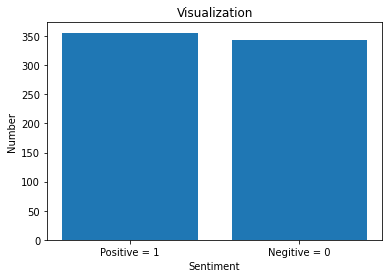

In [22]:
plt.bar(['Positive = 1','Negitive = 0'], n)
plt.xlabel('Sentiment')
plt.ylabel('Number')
plt.title('Visualization')
plt.show()

## Naive Bayes Model

<b>Prior Porbability:</b>
<br>
$$P(pos) = \frac{Count_{pos} + \alpha}{Count_{neg} + Count_{pos}} $$
<br>
<br>
$$P(neg) = \frac{Count_{neg} + \alpha}{Count_{neg} + Count_{pos}} $$
<br>
<b>Likelihood Porbability:</b>
<br>
<br>
$$parameters(pos) =P(W|pos) = \frac{Count(W)_{pos} + \alpha}{\sum{Count(W)_{pos}} + \alpha*V } $$
<br>
$$parameters(neg)=P(W|neg) = \frac{Count(W)_{neg} + \alpha}{\sum{Count(W)_{neg}} + \alpha*V} $$

<br><br>

<b>Posterior Probability</b>:
$$P(pos|(w1,w2....wn)) = \frac{P(pos)*\prod_{i=1}^{n}P(w_{i}|pos)}{P(pos)*\prod_{i=1}^{n}P(w_{i}|pos) + P(neg)*\prod_{i=1}^{n}P(w_{i}|neg)} $$
<br>
$$P(neg|(w1,w2....wn)) = \frac{P(neg)*\prod_{i=1}^{n}P(w_{i}|neg)}{P(pos)*\prod_{i=1}^{n}P(w_{i}|pos) + P(neg)*\prod_{i=1}^{n}P(w_{i}|neg)} 
$$


In [28]:
class NaiveBayesAlgo:

    def __init__(self, alpha=1):
        self.vocab={}
        self.prob_pos_words = {}
        self.prob_neg_words = {}  
        self.pos_count = 0
        self.neg_count = 0
        self.pos_prior = 0
        self.neg_prior = 0
        self.voc_len = 0
        self.alpha = alpha
    
    def vectorizer(self, data, label):
        '''
        Takes a list of sentences as input.
        Returns a dictionary containing unique words as keys and their respective count as values.
        '''
        dict_words = {}

        for line, label in zip(data, label):
            for text in line.split():
                if text not in stop_words:
                    pair = (text, label)
                    if pair in dict_words.keys():
                        dict_words[pair] += 1
                    else:
                        dict_words[pair] = 1

        return dict_words
        
 
    def fit(self, X, Y, initialize=False):
        '''
        Function to train our model.
        X = List of input sentences
        Y = List of labels for input sentences
        vectorized = Dictionary of counts of each unique word with their respective labels
        '''
 
        if initialize:
            self.vocab = {}
            self.prob_pos_words = {}
            self.prob_neg_words = {}
            self.pos_count = 0
            self.neg_count = 0
            self.pos_prior = 0
            self.neg_prior = 0
            self.voc_len = 0
        
        self.vocab = self.vectorizer(X, Y)
        
        self.pos_count = pd.DataFrame({'sentiments': Y})['sentiments'].value_counts()[0]
        self.neg_count = pd.DataFrame({'sentiments': Y})['sentiments'].value_counts()[1]
                        
        self.voc_len = len(list(self.vocab.keys()))
        for key in list(self.vocab.keys()):
            if key[1]==1:
                self.prob_pos_words[key[0]] = (self.vocab[key] + self.alpha) / (self.pos_count + (self.alpha * self.voc_len))
 
            if key[1]==0:
                self.prob_neg_words[key[0]] = (self.vocab[key] + self.alpha) / (self.neg_count + (self.alpha * self.voc_len))
 
        
        self.pos_prior = self.pos_count/(self.pos_count + self.neg_count)
        self.neg_prior = self.neg_count/(self.pos_count + self.neg_count)
        
        
    def predict(self, X):
        '''
        Input a list containing preprocessed tweets.
        '''
        
        pos_prob = self.pos_prior
        neg_prob = self.neg_prior
        y_true=[]
        for i in range(len(X)):
            for word in X[i].split():
                if word in list(self.prob_pos_words.keys()):
                    if self.prob_pos_words[word]>0:
                        pos_prob *= self.prob_pos_words[word]
                else:
                    pos_prob *= self.alpha / (self.pos_count + (self.alpha*self.voc_len))
 
                if word in list(self.prob_neg_words.keys()):
                    if self.prob_neg_words[word]>0:
                        neg_prob *= self.prob_neg_words[word]
                else:
                    neg_prob *= self.alpha / (self.neg_count + (self.alpha*self.voc_len))
                        
                    
 
 
            if pos_prob >= neg_prob:
                y_true.append(1)
            else:
                y_true.append(0)
            pos_prob = self.pos_prior
            neg_prob = self.neg_prior
            
 
        return y_true


    def partition(self, data, fold, k):
        '''
        Partitions the given data into train and test data, such that the k-1 folds are taken as train and kth fold is taken as test.
        
        data: Dictionary of values containing text and their sentiment labels, ie, 0 and 1.
        fold: index of fold to be taken as test.
        k: No. of folds
        '''
        
        size = len(dict_data['text'])
        start = int((size/k)*fold)
        end = int((size/k)*(fold+1))
        
        X_test = data['text'][start:end]
        Y_test = data['label'][start:end]
        
        vector = np.array(data['text'])
        X_train = np.concatenate((vector[:start], vector[end:]))
        vector = np.array(data['label'])
        Y_train = np.concatenate((vector[:start], vector[end:]))
        
        return X_train, X_test, Y_train, Y_test
    
    
    def cross_val(self, data, k):
        '''
        k-fold validation on the given data.
        data: Dictionary of values containing text and their sentiment labels, ie, 0 and 1.
        k: No. of folds
        '''
        
        TP, TN, FP, FN, Total, accuracy, recall, precision=0, 0, 0, 0, 0, 0, 0, 0
        
        for i in range(k):
            
            X_train, X_test, Y_train, Y_test = self.partition(data, i, k)            
            
            self.fit(X_train, Y_train, initialize=True)
            
            y_pred = self.predict(X_test)
            dict = self.report(Y_test, y_pred)
            
            TP+=dict['TP']
            TN+=dict['TN']
            FP+=dict['FP']
            FN+=dict['FN']
            Total+=dict['Total']
            accuracy+=dict['Accuracy']
            precision+=dict['Precision']
            recall+=dict['Recall']
            
            self.evaluate(X_test, Y_test)
        
        avg = {'TP':TP/k, 'TN':TN/k, 'FP':FP/k, 'FN':FN/k, 'Total':Total/k, 'Accuracy':accuracy/k, 'Recall':recall/k, 'Precision':precision/k}
        
        print('Final Classification Report') 
        n = np.array(list(avg.items()))
        df = pd.DataFrame(n[:,1], index=n[:,0], columns=[''])
        print(df)
        self.confusion_matrix(avg)
        
    
    def evaluate(self, x_test, y_test):
        '''
        Funciton to evaluate our model.
        '''

        y_pred = self.predict(x_test)
        dict = self.report(y_pred, y_test)
        print('Classification Report') 
        n = np.array(list(dict.items()))
        df = pd.DataFrame(n[:,1], index=n[:,0], columns=[''])
        print(df)
        self.confusion_matrix(dict)
        
    
    def report(self, y_pred, y_test):
        '''
        Input: list of predicted and true labels.
        Ouput: Dictionary of TP, TN, FP, FN, Total, Accuracy, Recall, Precision
        '''
        
        TP=0
        TN=0
        FP=0
        FN=0
        Total=len(y_pred)
        for pred, test in zip(y_pred, y_test):
            if pred==test:
                if pred==0:
                    TN+=1
                else:
                    TP+=1
            else:
                if pred==1:
                    FP+=1
                else:
                    FN+=1
        
        accuracy = (TP+TN) / Total
        recall = TP / (TP+FN)
        precision = TP / (TP+FP)
        
        return {'TP':TP, 'TN':TN, 'FP':FP, 'FN':FN, 'Total':Total, 'Accuracy':accuracy, 'Recall':recall, 'Precision':precision}
        
    def confusion_matrix(self, report_val):
        '''
        Confusion Matrix of the given data.
        '''
        
        fig, ax = plt.subplots()
        classes = ['Positive', 'Negitive']
        t = report_val['Total']
        report = np.array([[report_val['TN']/t, report_val['FP']/t], [report_val['FN']/t, report_val['TP']/t]])
        im = ax.imshow(report, cmap = 'Blues')

        ax.set_xticks(np.arange(len(classes)))
        ax.set_yticks(np.arange(len(classes)))

        ax.set_xticklabels(classes)
        ax.set_yticklabels(classes)


        plt.setp(ax.get_xticklabels(), rotation_mode="anchor")
        
        group_names = ['True Neg','False Pos', 'False Neg','True Pos']
        group_percentages = ['{0:.2%}'.format(value) for value in report.flatten()]

        labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
        labels = np.asarray(labels).reshape(2,2)

        for i in range(len(classes)):
            for j in range(len(classes)):
                text = ax.text(j, i, labels[i, j], ha="center", va="center")

        ax.set_title('Confusion Matrix', fontdict = {'size':18}, pad = 20)
        
        fig.tight_layout()
        plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
        plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
        plt.show()
        

## Training

In [29]:
NB = NaiveBayesAlgo()

<b> Training and evaluating the model with train and test data, which have sizes in the ratio 7:3. This is 2-fold cross validation.
Done to test the model.</b>

In [30]:
%%time
NB.fit(X_train, Y_train, initialize=True)

CPU times: user 19.2 ms, sys: 0 ns, total: 19.2 ms
Wall time: 19.5 ms


In [31]:
print(NB.pos_prior, NB.neg_prior, NB.pos_count, NB.neg_count)

0.5055959709009513 0.4944040290990487 1807 1767


## Evaluation

<b> Evaluating for test data. </b>

Classification Report
                             
TP                        120
TN                        121
FP                         35
FN                         24
Total                     300
Accuracy   0.8033333333333333
Recall     0.8333333333333334
Precision  0.7741935483870968


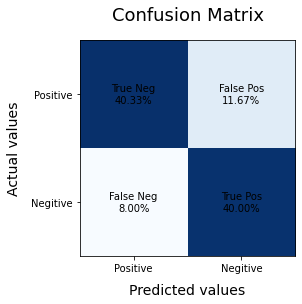

In [32]:
NB.evaluate(X_test, Y_test)

## Cross Validation

Classification Report
                            
TP                        72
TN                        45
FP                        20
FN                         5
Total                    142
Accuracy   0.823943661971831
Recall     0.935064935064935
Precision  0.782608695652174


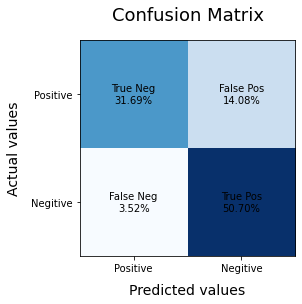

Classification Report
                             
TP                         68
TN                         53
FP                         17
FN                          5
Total                     143
Accuracy   0.8461538461538461
Recall     0.9315068493150684
Precision                 0.8


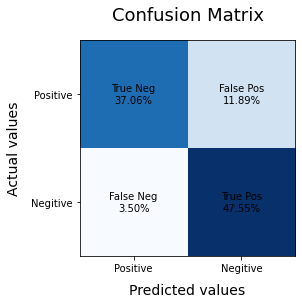

Classification Report
                             
TP                         65
TN                         49
FP                         19
FN                         10
Total                     143
Accuracy   0.7972027972027972
Recall     0.8666666666666667
Precision  0.7738095238095238


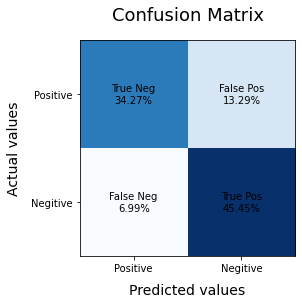

Classification Report
                             
TP                         65
TN                         47
FP                         24
FN                          7
Total                     143
Accuracy   0.7832167832167832
Recall     0.9027777777777778
Precision  0.7303370786516854


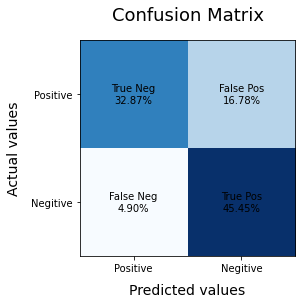

Classification Report
                             
TP                         52
TN                         62
FP                         15
FN                         14
Total                     143
Accuracy   0.7972027972027972
Recall     0.7878787878787878
Precision  0.7761194029850746


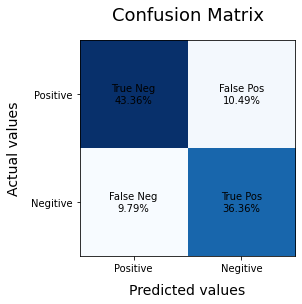

Classification Report
                             
TP                         58
TN                         52
FP                         21
FN                         12
Total                     143
Accuracy   0.7692307692307693
Recall     0.8285714285714286
Precision  0.7341772151898734


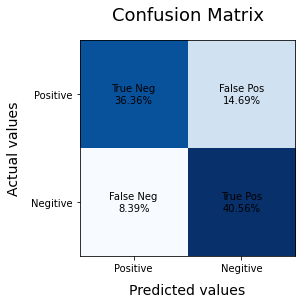

Classification Report
                             
TP                         51
TN                         59
FP                         17
FN                         16
Total                     143
Accuracy   0.7692307692307693
Recall     0.7611940298507462
Precision                0.75


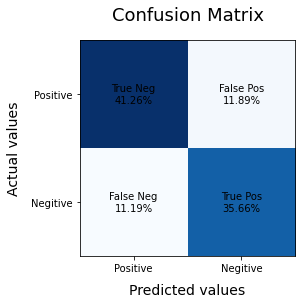

Final Classification Report
                             
TP          61.57142857142857
TN          52.42857142857143
FP          9.857142857142858
FN                       19.0
Total      142.85714285714286
Accuracy   0.7980259177442276
Recall     0.7638645594697616
Precision  0.8590943535893444


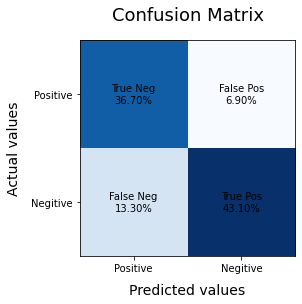

In [33]:
NB.cross_val(dict_data, 7)

<b>Final Classification Report</b>

Average values after 7-Fold Cross Validation:
<ol>
    <li>Accuracy   80.20%<br></li>
    <li>Recall     76.37%<br></li>
    <li>Precision  86.95%<br></li>
 </ol>
 
 Note: Please check the last heat map in the above cell.

## Predict

In [ ]:
test = ['there way for plug here the unless converter ',
 'good case excellent value ',
 'great for the jawbone ']
NB.predict(test)

## Limitations of Naive Bayes Classifier

<ol>
    <li>Naive Bayes doesnot consider the semantic relation between the words in a sentence (in the case of sentiment analysis done with Naive Bayes), that is, aive Bayes assumes that all features are independent. This is not very accurate, as in the wild (real life) tasks, occurance of independence is very rare.</li>
    <li>This algorithm faces the ‘zero-frequency problem’ where it assigns zero probability to a categorical variable, if the category in the test data set wasn’t available in the training dataset. Smoothening techniques like the laplace constant (used here) are used to overcome this limitation.</li>
    <li>In some tasks,the estimations can be wrong, methods other than probability outputs should be considered.</li>
</ol>

In [ ]:
a = 3
np.log(np.e)